In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Importing the Dataset and Preprocessing

In [2]:
# Load the datasets
properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv')

# Join the datasets on the 'parcelid' column
merged_data = pd.merge(train, properties, on='parcelid', how='left')

merged_data['latitude'] = merged_data['latitude']/1000000
merged_data['longitude'] = merged_data['longitude']/1000000

# Setting date as index
merged_data['transactiondate'] = pd.to_datetime(merged_data['transactiondate'])
merged_data.set_index('transactiondate', inplace=True)

# Select the columns you're interested in
features = ['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt']  # Add or remove features as needed
descriptive_stats = merged_data[features].describe()

geocolumns = ['latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
              'regionidzip', 'censustractandblock', 'rawcensustractandblock']

geoprop = merged_data[geocolumns]

# Drop rows without latitude and longitude
geoprop.dropna(axis=0, subset=['latitude', 'longitude'], inplace=True)


from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

def fillna_knn(df, base, target, fraction=1, threshold=10):
    assert isinstance(base, list) or isinstance(base, np.ndarray) and isinstance(target, str)
    whole = [target] + base

    miss = df[target].isnull()
    notmiss = ~miss
    nummiss = miss.sum()

    enc = OneHotEncoder()
    X_target = df.loc[notmiss, whole].sample(frac=fraction)
    
    # Fit and transform the target column
    enc.fit(X_target[target].unique().reshape((-1, 1)))
    Y = enc.transform(X_target[target].values.reshape((-1, 1))).toarray()
    X = X_target[base]

    # Fitting the KNN model
    n_neighbors = 10
    clf = KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(X, Y)

    # Predicting the missing values
    Z = clf.predict(df.loc[miss, base])

    # Replacing the missing values in the original dataframe
    numunpredicted = (Z == 0).all(axis=1).sum()
    if numunpredicted / nummiss * 100 < threshold:
        #print('writing result to df')
        df.loc[miss, target] = np.dot(Z, enc.categories_[0])
        #print('num of unpredictable data:', numunpredicted)
    #else:
    #    print('out of threshold: {}% > {}%'.format(numunpredicted / nummiss * 100, threshold))

# Filling the missing values to the most missing values
merged_data.dropna(axis=0, subset=['latitude', 'longitude'], inplace=True)

fillna_knn(df=merged_data, base=['latitude', 'longitude'], target='regionidcity', fraction=0.15)

fillna_knn(df=merged_data, base=['latitude', 'longitude'], target='regionidzip', fraction=0.15)


columns_to_drop = [
    'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedfloor1squarefeet', 
    'finishedsquarefeet50', 'storytypeid', 'buildingclasstypeid', 
    'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 
    'numberofstories', 'rawcensustractandblock', 'censustractandblock', 
    'assessmentyear', 'parcelid', 'transactiondate', 'basementsqft', 'yardbuildingsqft26','propertyzoningdesc','regionidneighborhood','calculatedbathnbr','propertycountylandusecode'
]

# Assuming your DataFrame is named 'merged_data'
merged_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# Impute 0
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag"]

# Impute mode
impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", 
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

# Impute median 
impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude","finishedsquarefeet12","taxvaluedollarcnt"
                      ,"taxamount"]

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd

# Define your ColumnTransformer (as you did)
univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)

# Fit and transform the data
transformed_data = univariate_impute_pipe.fit_transform(merged_data)

# Get the names of the columns transformed
transformed_columns = impute_0_vars + impute_mode_vars + impute_median_vars

# Identify columns that were 'passed through'
remainder_columns = [col for col in merged_data.columns if col not in transformed_columns]

# Combine all column names
all_columns = transformed_columns + remainder_columns

# Create DataFrame from the transformed data
merged_data = pd.DataFrame(transformed_data, columns=all_columns, index=merged_data.index)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
import pandas as pd

# Define your column names for categorical and numerical variables
cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

# Define your ColumnTransformer with multivariate imputation
multivariate_impute_pipe = ColumnTransformer([
        ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
        ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
    ],
    remainder='passthrough'
)

# Fit and transform the data
transformed_data = multivariate_impute_pipe.fit_transform(merged_data)

# Get the names of the columns transformed
transformed_columns = cat_impute_vars + numeric_impute_vars

# Identify columns that were 'passed through'
remainder_columns = [col for col in merged_data.columns if col not in transformed_columns]

# Combine all column names
all_columns = transformed_columns + remainder_columns

# Create DataFrame from the transformed data
transformed_merged_data = pd.DataFrame(transformed_data, columns=all_columns, index=merged_data.index)
transformed_merged_data.reset_index(inplace=True)

# Now transformed_merged_data is your new DataFrame with imputations

#Additional pre-processing steps added

transformed_merged_data.drop(columns=['fips','latitude','longitude'], inplace=True, errors='ignore')

transformed_merged_data.loc[transformed_merged_data['taxdelinquencyflag']=='Y', 'taxdelinquencyflag'] = 1

transformed_merged_data.loc[transformed_merged_data['hashottuborspa']==True, 'hashottuborspa'] = 1
transformed_merged_data.loc[transformed_merged_data['fireplaceflag']==True, 'fireplaceflag'] = 1

transformed_merged_data['hashottuborspa'].fillna(0,inplace=True)
transformed_merged_data['pooltypeid10'].fillna(0,inplace=True)
transformed_merged_data['pooltypeid7'].fillna(0,inplace=True)
transformed_merged_data['threequarterbathnbr'].fillna(0,inplace=True)
transformed_merged_data['fireplaceflag'].fillna(0,inplace=True)
transformed_merged_data['taxdelinquencyyear'].fillna(0,inplace=True)
transformed_merged_data['fullbathcnt'].fillna(0,inplace=True)

Feature Engineering

In [3]:
transformed_merged_data['transaction_month'] = pd.DatetimeIndex(transformed_merged_data['transactiondate']).month
transformed_merged_data.drop(columns=['transactiondate'], inplace=True, errors='ignore')

transformed_merged_data['years_life'] = 2018 - transformed_merged_data['yearbuilt']
transformed_merged_data.drop(columns=['yearbuilt'], inplace=True, errors='ignore')

transformed_merged_data['bathroom_bedroom_ratio'] = 0 
for i in range(len(transformed_merged_data)):
    if transformed_merged_data.loc[i]['bedroomcnt']!=0 and transformed_merged_data.loc[i]['bathroomcnt']!=0:
        transformed_merged_data.at[i,'bathroom_bedroom_ratio'] = transformed_merged_data.loc[i]['bedroomcnt']/transformed_merged_data.loc[i]['bathroomcnt']

transformed_merged_data['avg_size_pool'] = 0 
for i in range(len(transformed_merged_data)):
    if transformed_merged_data.loc[i]['poolsizesum']!=0 and transformed_merged_data.loc[i]['poolcnt']!=0:
        transformed_merged_data.at[i,'avg_size_pool'] = transformed_merged_data.loc[i]['poolsizesum']/transformed_merged_data.loc[i]['poolcnt']

transformed_merged_data['pools_patio_ratio'] = 0 
for i in range(len(transformed_merged_data)):
    if transformed_merged_data.loc[i]['poolsizesum']!=0 and transformed_merged_data.loc[i]['yardbuildingsqft17']!=0:
        transformed_merged_data.at[i,'pools_patio_ratio'] = transformed_merged_data.loc[i]['poolsizesum']/transformed_merged_data.loc[i]['yardbuildingsqft17']

Correlation Analysis & Feature Selection using Lasso Regression and Random Forest Feature Importance

In [4]:
df = transformed_merged_data.copy()

X = df.drop(['logerror'], axis=1)
y = df[['logerror']]

categorical_fields = ['airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcounty', 'pooltypeid2', 'decktypeid', 'taxdelinquencyflag', 'buildingqualitytypeid', 'hashottuborspa', 'pooltypeid10', 'pooltypeid7', 'regionidcity', 'regionidzip', 'fireplaceflag']

X_numeric = X.drop(columns=categorical_fields, axis=1)

X_categorical = X[categorical_fields]

corr = X_numeric.corr()
corr = corr.mask(corr.abs() <= 0.8, 0)
#corr.to_csv('correlation_matrix.csv')


#Feature Selection using Lasso Regression

#Min Max Scaling on X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = df.drop(columns=['logerror'], errors='ignore')
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std,columns = X.columns)
y = df['logerror']

#Import train_test_split

from sklearn.model_selection import train_test_split
X_std_train, X_std_test, y_train,y_test = train_test_split(X_std,y,test_size=0.3,random_state=0)

#Run lasso for feature selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

feature_names = X.columns
lasso = Lasso(alpha=0.00000005,max_iter=1000, random_state=0)
lasso.fit(X_std_train, y_train)
with pd.option_context("display.max_rows",None,"display.max_columns",None):
    print(pd.DataFrame(list(zip(X_std.columns,lasso.coef_)), columns = ['predictor','coefficient']))


#Feature Importance Score using Random Forest

df = transformed_merged_data.copy()

X = df.drop(['logerror'], axis=1)
y = df['logerror']

categorical_fields = ['transaction_month','airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcounty', 'pooltypeid2', 'decktypeid', 'taxdelinquencyflag', 'buildingqualitytypeid', 'hashottuborspa', 'pooltypeid10', 'pooltypeid7', 'regionidcity', 'regionidzip', 'fireplaceflag']

for col in categorical_fields:
    X[col] = X[col].astype('category')


from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)
model = randomforest.fit(X, y)

feature_imp_df = pd.DataFrame(list(zip(X.columns,model.feature_importances_)), columns = ['predictor','feature importance'])

#feature_imp_df.to_csv('random_forest_feature_importance.csv',index=False)

Apply Feature Selection for Modelling

In [ ]:
df = transformed_merged_data.copy()

corr_columns_remove = ['fullbathcnt','finishedsquarefeet12','garagetotalsqft','structuretaxvaluedollarcnt','landtaxvaluedollarcnt','taxvaluedollarcnt','avg_size_pool']

lasso_columns_remove = ['decktypeid', 'fireplacecnt', 'fireplaceflag', 'hashottuborspa', 'poolcnt', 'pools_patio_ratio', 'poolsizesum', 'taxdelinquencyflag', 'transaction_month']

df = df.drop(columns=corr_columns_remove, axis=1)

df = df.drop(columns=lasso_columns_remove, axis=1)

X = df.drop(['logerror'], axis=1)
y = df['logerror']

categorical_fields = ['airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcounty', 'pooltypeid2', 'buildingqualitytypeid', 'pooltypeid10', 'pooltypeid7', 'regionidcity', 'regionidzip']

removed_cols = set(corr_columns_remove + lasso_columns_remove)

categorical_fields = [field for field in categorical_fields if field not in removed_cols]

numerical_fields = X.columns.difference(categorical_fields)

for col in categorical_fields:
    X[col] = X[col].astype('category')

Remove Outliers using Isolation Forest

In [ ]:
preprocessed_outliers = df.drop(columns=categorical_fields, axis=1)
from sklearn.ensemble import IsolationForest
isolforest = IsolationForest(contamination=0.05,random_state=0)
pred = isolforest.fit_predict(preprocessed_outliers)

from numpy import where
anomaly_index = where(pred==-1)
anomaly_values = df.iloc[anomaly_index]

X.drop(anomaly_values.index,inplace=True, errors='ignore')
y.drop(anomaly_values.index,inplace=True, errors='ignore')

Train-Test Split Without Standardizing Predictors

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)

Code for Standardizing Numeric Predictors

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_numeric = X_train[numerical_fields]
X_test_numeric = X_test[numerical_fields]

# Standardize predictors
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train_numeric)
X_test_scaled_numeric = scaler.transform(X_test_numeric)

X_train_scaled_numeric = pd.DataFrame(X_train_scaled_numeric, columns=numerical_fields)
X_test_scaled_numeric = pd.DataFrame(X_test_scaled_numeric, columns=numerical_fields)

X_train_scaled = pd.concat([X_train_scaled_numeric, X_train[categorical_fields].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test_scaled_numeric, X_test[categorical_fields].reset_index(drop=True)], axis=1)

Code for Dummifying Categorical Predictors without Standardization

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_fields)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_fields)

Code for Dummifying Categorical Predictors with Standardization

In [ ]:
X_train_scaled_encoded = pd.get_dummies(X_train_scaled, columns=categorical_fields)
X_test_scaled_encoded = pd.get_dummies(X_test_scaled, columns=categorical_fields)

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
model = lm.fit(X_train_scaled_encoded,y_train)

y_pred = model.predict(X_test_scaled_encoded)

lm_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE using Linear Regression = {lm_mse}")

Test MSE using Linear Regression = 226281699205811.72


Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=100)
model = ridge.fit(X_train_scaled_encoded,y_train)

y_pred = model.predict(X_test_scaled_encoded)

ridge_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE using Ridge regression = {ridge_mse}")

ridge_df = pd.DataFrame(list(zip(X_train_encoded.columns,ridge.coef_)), columns = ['predictor','coefficient'])

Test MSE using Ridge regression = 0.020580943156582678


Hyperparameter Tuning for Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Define the Ridge Regression model
ridge = Ridge()

# Define a grid of alpha values to search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled_encoded, y_train)

results = grid_search.cv_results_
for mean_score, alpha in zip(results['mean_test_score'], param_grid['alpha']):
    print(f"Alpha: {alpha}, MSE: {round(-mean_score,5)}")

# Get the best alpha value and corresponding model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test_scaled_encoded)

# Calculate mean squared error with the best model
best_ridge_mse = mean_squared_error(y_test, y_pred)

print(f"Best Alpha value for Ridge Regression is: {best_alpha}")

print(f"Best Test MSE using Ridge regression = {round(best_ridge_mse,5)}")

Alpha: 0.001, MSE: 0.02576
Alpha: 0.01, MSE: 0.02576
Alpha: 0.1, MSE: 0.02573
Alpha: 1, MSE: 0.02567
Alpha: 10, MSE: 0.02555
Alpha: 100, MSE: 0.02543
Best Alpha value for Ridge Regression is: 100
Best Test MSE using Ridge regression = 0.02661


Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha=0.0001, max_iter=10000)
model = lasso.fit(X_train_scaled_encoded,y_train)

y_pred = model.predict(X_test_scaled_encoded)

lasso_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE using Lasso regression = {lasso_mse}")

Test MSE using Lasso regression = 0.020587162269535213


Hyperparameter Tuning for Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the Lasso Regression model
lasso = Lasso(max_iter=10000)

# Define a grid of alpha values to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  # Regularization strength
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the encoded training data
grid_search.fit(X_train_scaled_encoded, y_train)

# Get the MSE for each alpha value
results = grid_search.cv_results_
for mean_score, alpha in zip(results['mean_test_score'], param_grid['alpha']):
    mse_score = -mean_score  # Convert negative score to positive for MSE
    print(f"Alpha: {alpha}, MSE: {mse_score:.4f}")

# Get the best alpha value and corresponding model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test_scaled_encoded)

# Calculate mean squared error with the best model
best_lasso_mse = mean_squared_error(y_test, y_pred)
print(f"Best Alpha: {best_alpha}")
print(f"Best Test MSE using Lasso regression: {best_lasso_mse:.4f}")

KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn_regressor = KNeighborsRegressor(n_neighbors=20)

model = knn_regressor.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)  

mse_knn = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) for KNeighborsRegressor: {mse_knn}")


Mean Squared Error (MSE) for KNeighborsRegressor: 0.021442088643726594


Hyperparameter Tuning for KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the KNeighborsRegressor model
knn_regressor = KNeighborsRegressor()

# Define a grid of n_neighbors values to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 15, 20]} 

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the MSE for each n_neighbors value
results = grid_search.cv_results_
for mean_score, n_neighbors in zip(results['mean_test_score'], param_grid['n_neighbors']):
    mse_score = -mean_score  # Convert negative score to positive for MSE
    print(f"n_neighbors: {n_neighbors}, MSE: {round(mse_score,4)}")

# Get the best n_neighbors value and corresponding model
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate mean squared error with the best model
print(f"Best n_neighbors for KNN is: {best_n_neighbors}")
best_knn_mse = mean_squared_error(y_test, y_pred)
print(f"Best Test MSE using KNeighborsRegressor = {round(best_knn_mse,4)}")

n_neighbors: 1, MSE: 0.0482
n_neighbors: 3, MSE: 0.0319
n_neighbors: 5, MSE: 0.0292
n_neighbors: 7, MSE: 0.028
n_neighbors: 10, MSE: 0.0272
n_neighbors: 15, MSE: 0.0266
n_neighbors: 20, MSE: 0.0263
Best n_neighbors for KNN is: 20
Best Test MSE using KNeighborsRegressor = 0.0275


Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt_regressor = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=10, random_state=0)

model = dt_regressor.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE) for DecisionTreeRegressor: {mse_dt}")

Mean Squared Error (MSE) for DecisionTreeRegressor: 0.020627955452411396


Hyperparameter Tuning for Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the DecisionTreeRegressor model
dt_regressor = DecisionTreeRegressor()

# Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_test_pred = best_model.predict(X_test)

# Calculate mean squared error with the best model
best_mse_dt = mean_squared_error(y_test, y_test_pred)
print(f"Best Test MSE using DecisionTreeRegressor: {best_mse_dt:.4f}")
print(f"Best Hyperparameters: {best_params}")

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

randomforest = RandomForestRegressor(random_state=0, n_estimators=300, max_features='log2', max_depth=10, min_samples_leaf=2, min_samples_split=5)
model_rf = randomforest.fit(X_train, y_train)

y_test_pred = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE): {mse_rf}")


Mean Squared Error (MSE): 0.02040994232126622


Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the RandomForestRegressor model
randomforest = RandomForestRegressor(random_state=0)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300]  # Number of trees in the forest
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=randomforest, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_test_pred = best_model.predict(X_test)

# Calculate mean squared error with the best model
best_mse_rf = mean_squared_error(y_test, y_test_pred)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test MSE using RandomForestRegressor: {best_mse_rf:.4f}")

Best Hyperparameters: {'n_estimators': 300}
Best Test MSE using RandomForestRegressor: 0.0278


Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gbt = GradientBoostingRegressor(random_state=0, n_estimators=50, max_features=None, max_depth=3, min_samples_leaf=1, min_samples_split=2, learning_rate=0.1)
model_gbt = gbt.fit(X_train, y_train)

y_test_pred = model_gbt.predict(X_test)

mse_gbt = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE): {mse_gbt}")


Mean Squared Error (MSE): 0.020532961522145086


Hyperparameter Tuning For Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the GradientBoostingRegressor model
gbt = GradientBoostingRegressor(random_state=0)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5],  # Step size shrinkage used in each boosting stage
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gbt, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_test_pred = best_model.predict(X_test)

# Calculate mean squared error with the best model
best_mse_gbt = mean_squared_error(y_test, y_test_pred)
print(f"Best Test MSE using GradientBoostingRegressor: {best_mse_gbt:.4f}")
print(f"Best Hyperparameters: {best_params}")

Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp_regressor = MLPRegressor(hidden_layer_sizes=(64, 32), momentum=0.9, random_state=0)

mlp_regressor.fit(X_train_scaled_encoded, y_train)

y_test_pred = mlp_regressor.predict(X_test_scaled_encoded)

mse_ann_scaled = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE) for ANN: {mse_ann_scaled}")


Mean Squared Error (MSE) for ANN: 0.02300740798381119


Hyperparameter Tuning for Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the MLPRegressor model
mlp_regressor = MLPRegressor(random_state=0)

# Define a grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [(64, 32), (32, 16), (128, 64)],  # Structure of hidden layers
    'activation': ['relu', 'tanh'],  # Activation function
    'solver': ['adam', 'sgd'],  # Solver for weight optimization
    'alpha': [0.0001, 0.001, 0.01]  # L2 penalty (regularization term) parameter
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled_encoded, y_train)

# Get the best parameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_test_pred = best_model.predict(X_test_scaled_encoded)

# Calculate mean squared error with the best model
best_mse_ann = mean_squared_error(y_test, y_test_pred)
print(f"Best Test MSE using MLPRegressor: {best_mse_ann:.4f}")
print(f"Best Hyperparameters: {best_params}")

Best Model Selected - Random Forest - Model Interpretation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

randomforest = RandomForestRegressor(random_state=0, n_estimators=300, max_features='log2', max_depth=10, min_samples_leaf=2, min_samples_split=5)
model_rf = randomforest.fit(X_train, y_train)

y_test_pred = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE): {mse_rf}")

Mean Squared Error (MSE): 0.02040994232126622


Feature Importance Scores

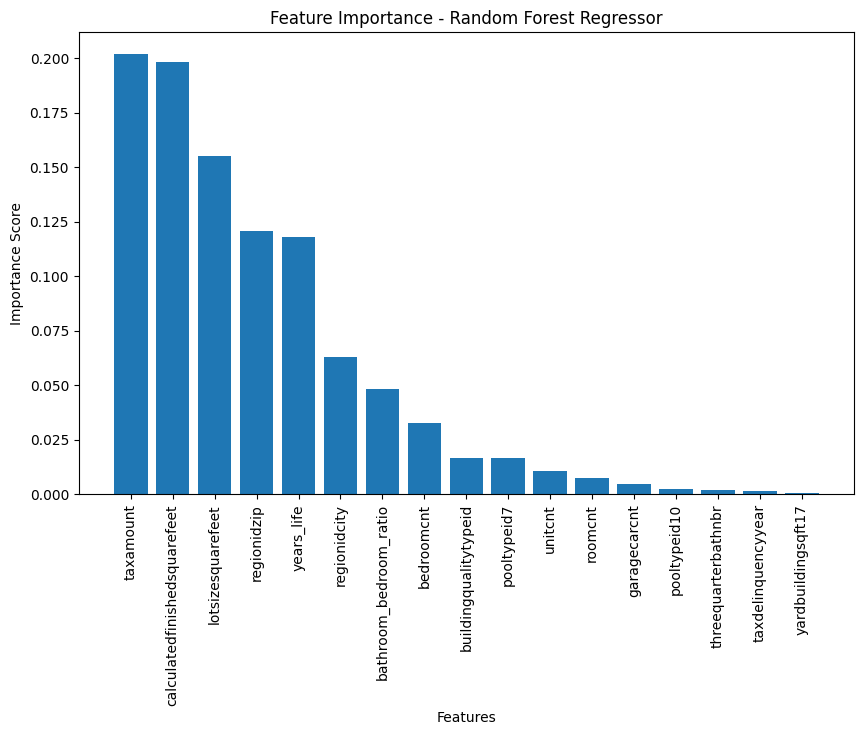

In [ ]:
import matplotlib.pyplot as plt

# Feature Importance
importance = model_rf.feature_importances_
sorted_idx = importance.argsort()[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importance[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

Prediction Analysis

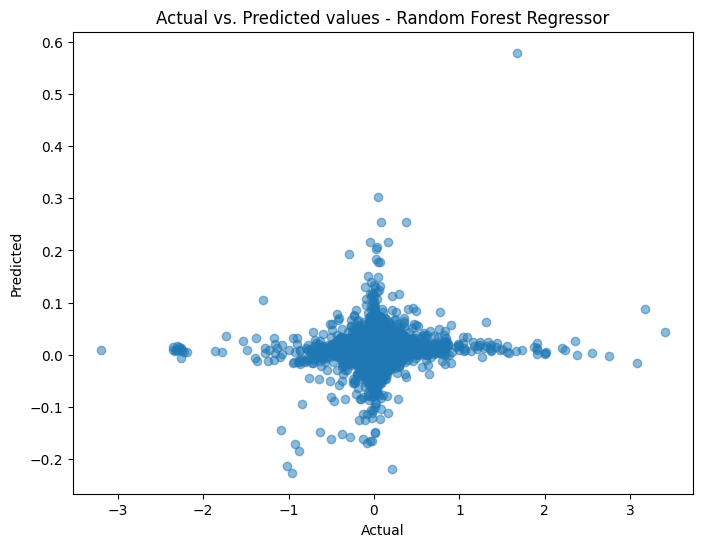

In [ ]:
# Visualize Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted values - Random Forest Regressor')
plt.show()